In [1]:
# using Google CoLab as my coding environment 
# checking the GPU 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# data normalization
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y


# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

print("The shape of x_train", x_train.shape)
print("The shape of y_train", y_train.shape)
print("The shape of x_test", x_test.shape)
print("The shape of y_test", y_test.shape)

Using TensorFlow backend.


170500096/170498071 [==============================] - 4s 0us/step
The shape of x_train (50000, 3072)
The shape of y_train (50000, 10)
The shape of x_test (10000, 3072)
The shape of y_test (10000, 10)


In [0]:
from keras.layers import BatchNormalization


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
# hyperparameters
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [5]:
# using SGD as optimizer for training with different values of patience in ReduceLROnPlateau
 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
patience= [3,5,7,9]
results = {} # for plotting later
for pt in patience:
  
    from keras.callbacks import ReduceLROnPlateau

    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=pt, 
                                  verbose=1)
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with different patience (ReduceLROnPlateau) = %.6f" % (pt))
    model = build_mlp(input_shape=x_train.shape[1:])
    # model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle= True,
              callbacks = [reduce_lr],
              verbose=2)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-Reduce_LearningRate-patience%s" % str(pt)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0804 15:07:09.270512 139763963905920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0804 15:07:09.271837 139763963905920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 15:07:09.283853 139763963905920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 15:07:09.284870 139763963905920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W080

Experiment with different patience (ReduceLROnPlateau) = 3.000000


W0804 15:07:09.679149 139763963905920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0804 15:07:09.794406 139763963905920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 4s - loss: 2.1976 - acc: 0.2737 - val_loss: 2.1617 - val_acc: 0.3210
Epoch 2/50
 - 1s - loss: 1.7430 - acc: 0.3932 - val_loss: 1.8001 - val_acc: 0.3857
Epoch 3/50
 - 1s - loss: 1.6161 - acc: 0.4394 - val_loss: 1.6843 - val_acc: 0.4115
Epoch 4/50
 - 1s - loss: 1.5400 - acc: 0.4645 - val_loss: 1.6323 - val_acc: 0.4241
Epoch 5/50
 - 1s - loss: 1.4880 - acc: 0.4817 - val_loss: 1.5935 - val_acc: 0.4437
Epoch 6/50
 - 1s - loss: 1.4424 - acc: 0.4970 - val_loss: 1.5707 - val_acc: 0.4501
Epoch 7/50
 - 1s - loss: 1.4033 - acc: 0.5128 - val_loss: 1.5323 - val_acc: 0.4596
Epoch 8/50
 - 1s - loss: 1.3676 - acc: 0.5259 - val_loss: 1.5048 - val_acc: 0.4688
Epoch 9/50
 - 1s - loss: 1.3348 - acc: 0.5376 - val_loss: 1.4984 - val_acc: 0.4735
Epoch 10/50
 - 1s - loss: 1.3040 - acc: 0.5484 - val_loss: 1.4876 - val_acc: 0.4794
Epoch 11/50
 - 1s - loss: 1.2778 - acc: 0.5577 - val_loss: 1.4902 - val_acc: 0.4722
Epoch 12/50
 - 1s - loss: 1.2497 - 

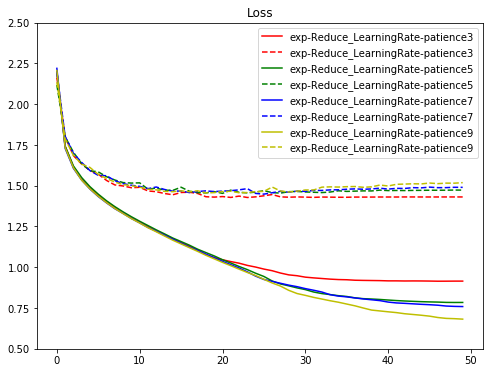

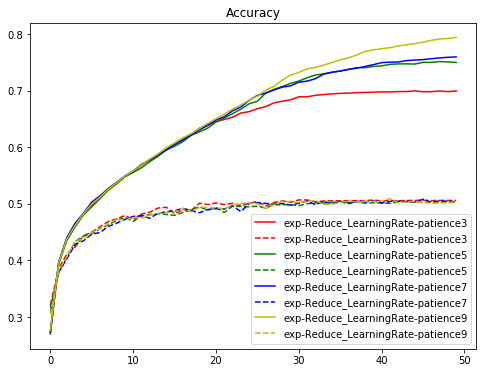

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0.5, 2.5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [7]:
# using SGD as optimizer for training with different values of factor in ReduceLROnPlateau
results1={}
factor = [0.1,0.3,0.5,0.7,0.9]
for fct in factor:
  
    from keras.callbacks import ReduceLROnPlateau

    reduce_lr = ReduceLROnPlateau(factor = fct, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=9, 
                                  verbose=1)
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with different factor (ReduceLROnPlateau) = %.6f" % (fct))
    model = build_mlp(input_shape=x_train.shape[1:])
    # model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle= True,
              callbacks = [reduce_lr],
              verbose=2)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-Reduce_LearningRate-factor%s" % str(fct)
    results1[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with different factor (ReduceLROnPlateau) = 0.100000
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 2s - loss: 2.2122 - acc: 0.2728 - val_loss: 2.0912 - val_acc: 0.3155
Epoch 2/50
 - 1s - loss: 1.7439 - acc: 0.3941 - val_loss: 1.8099 - val_acc: 0.3725
Epoch 3/50
 - 1s - loss: 1.6180 - acc: 0.4337 - val_loss: 1.6844 - val_acc: 0.4180
Epoch 4/50
 - 1s - loss: 1.5456 - acc: 0.4601 - val_loss: 1.6454 - val_acc: 0.4257
Epoch 5/50
 - 1s - loss: 1.4890 - acc: 0.4817 - val_loss: 1.6014 - val_acc: 0.4389
Epoch 6/50
 - 1s - loss: 1.4431 - acc: 0.4960 - val_loss: 1.5720 - val_acc: 0.4457
Epoch 7/50
 - 1s - loss: 1.4036 - acc: 0.5112 - val_loss: 1.5464 - val_acc: 0.4587
Epoch 8/50
 - 1s - loss: 1.3692 - acc: 0.5245 - val_loss: 1.5382 - val_acc: 0.4617
Epoch 9/50
 - 1s - loss: 1.3369 - acc: 0.5359 - val_loss: 1.5253 - val_acc: 0.4672
Epoch 10/50
 - 1s - loss: 1.3070 - acc: 0.5470 - val_loss: 1.5132 - val_acc: 0.4639
Epoch 11/50
 - 1s - loss: 1.2797 - acc: 0.5559 - val_lo

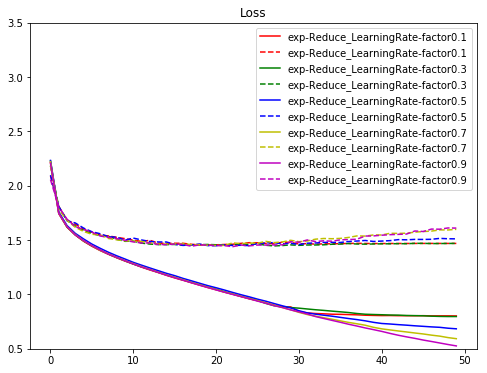

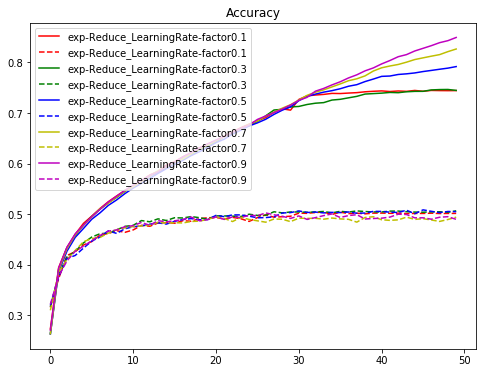

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results1.keys()):
    plt.plot(range(len(results1[cond]['train-loss'])),results1[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results1[cond]['valid-loss'])),results1[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0.5, 3.5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results1.keys()):
    plt.plot(range(len(results1[cond]['train-acc'])),results1[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results1[cond]['valid-acc'])),results1[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

the loss of training data is getting smaller as the factor change from 0.1 to 0.9. 
but the loss of validation data didn't change a lot.
Still, it seems like that as the factor is close to 1, the accuracy of training data will be higher 
however, the accuracy of validation data is not influenced by the factor

In [9]:
# using different optimizer for training
import itertools
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
opt_set = ["SGD", "Adam", "RMSprop"]

results2 = {}
factor = 0.9
patience = 9
for i , opt in enumerate(optimizer_set):
    print(opt)
  
    from keras.callbacks import ReduceLROnPlateau

    reduce_lr = ReduceLROnPlateau(factor = factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=patience, 
                                  verbose=2)
    
    print("Experiment with different optimizer : %.6s" % str(opt_set[i]))
    model1 = build_mlp(input_shape=x_train.shape[1:])
    # model.summary()
    model1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer = opt)
    print('hi')
    print(x_train.shape)
    print(y_train.shape)
    model1.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle= True,
              callbacks = [reduce_lr],
              verbose=2)
    
    # Collect results
    train_loss = model1.history.history["loss"]
    valid_loss = model1.history.history["val_loss"]
    train_acc = model1.history.history["acc"]
    valid_acc = model1.history.history["val_acc"]
    
    exp_name_tag = "exp-optimizer-%s" % str(opt_set[i])
    results2[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    #keras.backend.clear_session() # 把舊的 Graph 清掉

Experiment with different optimizer : SGD
hi
(50000, 3072)
(50000, 10)
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 2s - loss: 2.2083 - acc: 0.2665 - val_loss: 2.1095 - val_acc: 0.3169
Epoch 2/50
 - 1s - loss: 1.7433 - acc: 0.3922 - val_loss: 1.7736 - val_acc: 0.3866
Epoch 3/50
 - 1s - loss: 1.6222 - acc: 0.4322 - val_loss: 1.6814 - val_acc: 0.4137
Epoch 4/50
 - 1s - loss: 1.5535 - acc: 0.4577 - val_loss: 1.6331 - val_acc: 0.4275
Epoch 5/50
 - 1s - loss: 1.4989 - acc: 0.4773 - val_loss: 1.5909 - val_acc: 0.4430
Epoch 6/50
 - 1s - loss: 1.4539 - acc: 0.4924 - val_loss: 1.5797 - val_acc: 0.4435
Epoch 7/50
 - 1s - loss: 1.4136 - acc: 0.5063 - val_loss: 1.5377 - val_acc: 0.4598
Epoch 8/50
 - 1s - loss: 1.3799 - acc: 0.5182 - val_loss: 1.5183 - val_acc: 0.4589
Epoch 9/50
 - 1s - loss: 1.3455 - acc: 0.5312 - val_loss: 1.5117 - val_acc: 0.4660
Epoch 10/50
 - 1s - loss: 1.3129 - acc: 0.5427 - val_loss: 1.4931 - val_acc: 0.4736
Epoch 11/50
 - 1s - loss: 1.2848 - acc: 0.5543 -

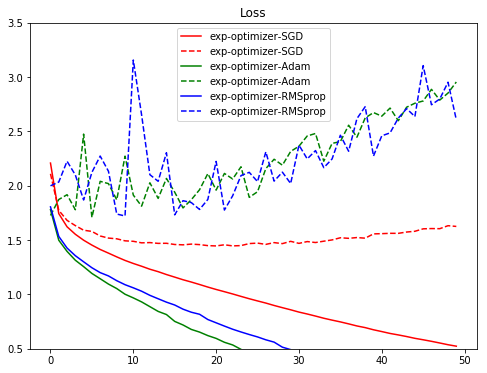

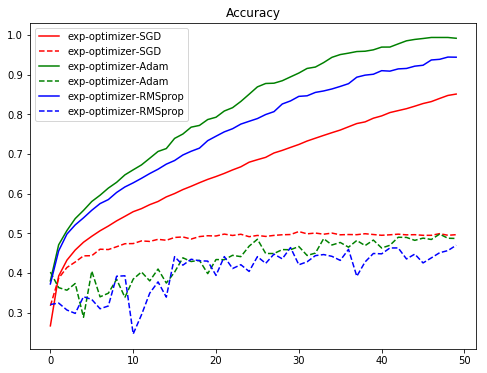

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train-loss'])),results2[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-loss'])),results2[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0.5, 3.5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train-acc'])),results2[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-acc'])),results2[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()